Dataset: Allegheny County COVID-19 Tests, Cases and Deaths

Our group metric to determine the best neighborhood was health and safety. My submetric is COVID positive test count per neighborhood. This matters when defining safety of a neighborhood because high COVID-19 case rates in certain neighborhoods may indicate reduced health from many factors like reduced access to hospitals, fewer precautions, less vaccinations, or lower access to proper COVID care. Therefore, a lower positivity rate suggests a safer neighborhood in terms of public health.

In this notebook, I’ll clean and analyze COVID test data from Allegheny County to identify which surrounding neighborhood had the lowest positivity rate.

Team Member: Gabi Fernandes

Link: https://data.wprdc.org/dataset/allegheny-county-covid-19-tests-cases-and-deaths

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [70]:
# import and display the data
url = "https://data.wprdc.org/datastore/dump/3869680f-8faa-4e8c-8c01-6aa1309c40ad"
covid = pd.read_csv(url)
covid.head()

,_id,neighborhood_municipality,month,infections,reinfections,total_infections,breakthrough_infections,deaths,breakthrough_deaths,hospitalizations,breakthrough_hospitalizations,pcr_tests,positive_pcr_tests
0,1292413,Allegheny Center (Pittsburgh),2020-03,2,0,2,0,0,0,0,0,11,3
1,1292414,Arlington (Pittsburgh),2020-03,3,0,3,0,0,0,0,0,17,5
2,1292415,Avalon,2020-03,3,0,3,3,0,0,0,0,18,0
3,1292416,Banksville (Pittsburgh),2020-03,3,0,3,0,0,0,0,0,20,2
4,1292417,Ben Avon,2020-03,1,0,1,0,0,0,0,0,8,0


The data is divided into columns that given information on COVID infection. The important columns that I used will be about the neighborhood/municipality, the total infections, and the pcr tests. I am going to clean the data to filter unwanted values:
* drop undefined/missing neighborhood names to avoid unknown geographic regions
* remove rows with pcr_tests == 0 to prevent divide by zero errors when calculating positivity rates for COVID
* group all City of Pittsburgh neighborhoods into one 'Pittsburgh (City Total)' entry, and keep all other Allegheny County municipalities. This lets the city appear as one comparable place and better aligns with my team members submetrics which have Pittsburgh as a city total, not individual municipalities. 

In [71]:
# remove the rows without neighborhood name
covid = covid.dropna(subset=['neighborhood_municipality'])

# remove undefined entries
covid = covid[covid['neighborhood_municipality'] != 'Undefined']

# PCR tests should be > 0
covid = covid[covid['pcr_tests'] > 0]

# identify City of Pittsburgh neighborhoods
mask_city = covid['neighborhood_municipality'].str.contains(r'\(Pittsburgh\)', case=False, na=False)

# collapse all City neighborhoods into a single group
covid['place'] = np.where(mask_city, 'Pittsburgh (City Total)', covid['neighborhood_municipality'])

I am going to compute two metrics for each neighborhood: 

1) total infections: the sum of all infections across the full period
* I measured the cumulative COVID infection rate over time for each neighborhood.
* Sensitive to population size and testing intensity; larger places often have more infections.
* Chosen here to show overall impact of COVID; this metric is combined with COVID positivity rate in the conclusion to determine which neighborhoods were least impacted by COVID.

2) positivity rate: total positive PCR tests / total PCR tests (overall)
* I computed one overall positivity rate per neighborhood using totals: total positive PCR tests / total PCR tests (across the full period).
* This is better than averaging monthly rates because months have very different testing volumes, so totals correctly weight heavy-testing periods.
* Interpretation: lower positivity is safer (less community spread and/or broader testing); higher positivity can reflect concentrated spread and/or under-testing.

In [72]:
# compute positivity rate
covid['positivity_rate'] = covid['positive_pcr_tests'] / covid['pcr_tests'] * 100

# group by place and sum up infections, tests, and positives
grouped = covid.groupby('place').sum(numeric_only=True)

# reset the index to turn place back into a column
grouped = grouped.reset_index()

# compute overall positivity rate from totals
grouped['positivity_rate'] = grouped['positive_pcr_tests'] / grouped['pcr_tests'] * 100

# sort by total infections
sorted_infections = grouped.sort_values(by='infections', ascending=False)

print('Top 10 Places by COVID-19 Infections:')
print(sorted_infections.head(10))


Top 10 Places by COVID-19 Infections:
                       place         _id  infections  reinfections  \
88   Pittsburgh (City Total)  4461548728       75575          5626   
84                Penn Hills    49272461       10358           865   
9                Bethel Park    49271099        8755           592   
73             Mount Lebanon    49272368        8329           509   
96                      Ross    49273818        8131           523   
71               Monroeville    49272180        8046           661   
72                      Moon    49270163        6997           488   
66                McCandless    49273905        6894           439   
102                   Shaler    49273343        6696           454   
90                      Plum    49273709        6526           508   

     total_infections  breakthrough_infections  deaths  breakthrough_deaths  \
88              81201                    31310     760                  153   
84              11223            

To visualize this data better, I will display a bar chart for the top 10 neighborhoods with the highest total infections and a bar chart with the top 10 neighborhoods with the highest overall positivity rates. 

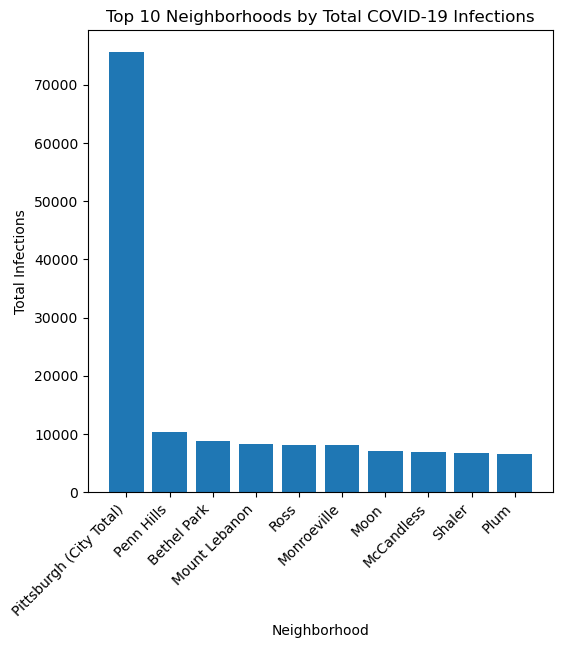

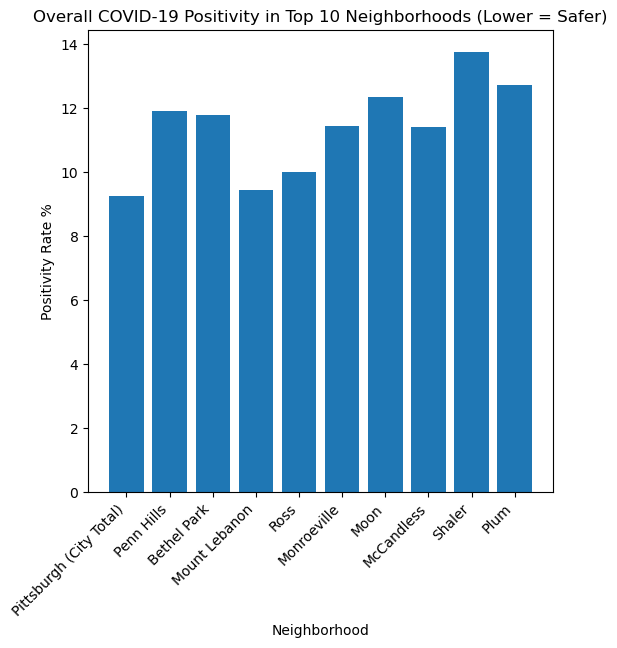

In [73]:
top10 = sorted_infections.head(10)

# top 10 neighborhoods with the most infections
plt.figure(figsize=(6,6))
plt.bar(top10['place'], top10['infections'])
plt.title('Top 10 Neighborhoods by Total COVID-19 Infections')
plt.xlabel('Neighborhood')
plt.ylabel('Total Infections')
plt.xticks(rotation=45, ha='right')
plt.show()

# positivity rates for the top 10 neighborhoods
plt.figure(figsize=(6,6))
plt.bar(top10['place'], top10['positivity_rate'])
plt.title('Overall COVID-19 Positivity in Top 10 Neighborhoods (Lower = Safer)')
plt.xlabel('Neighborhood')
plt.ylabel('Positivity Rate %')
plt.xticks(rotation=45, ha='right')
plt.show()

The places at the top of the infections chart have the highest total infections (often larger or more tested areas). The COVID positivity rate adds context: lower positivity means safer public health conditions (less community spread and/or broader testing), while higher positivity can reflect more concentrated spread and/or under-testing. This submetric complements our other Health & Safety indicators and will be combined with 911 and police data in our full score. 

To get a better idea of which places have the best health and safety, I will have to evaluate the data in the opposite way - get the places with the LOWEST total infections and lowest positivity rates. I will now take the data and produce two charts with this information so that it can be compared with the other submetrics of my team members to determine the best areas in terms of health and safety.

Bottom 10 Places by COVID-19 Infections:
                place       _id  infections  reinfections  total_infections  \
53          Haysville  40192579          11             2                13   
113          Trafford  36298792          12             2                14   
48          Glenfield  44081511          46             3                49   
68           Mcdonald  46680205          87             3                90   
106  South Versailles  49271341          91             7                98   
97      Rosslyn Farms  47981094          91             2                93   
8    Ben Avon Heights  47967070          96             6               102   
47       Glen Osborne  47973814         108             7               115   
120    West Elizabeth  49271225         114             8               122   
112         Thornburg  49275981         132             8               140   

     breakthrough_infections  deaths  breakthrough_deaths  hospitalizations  \
53        

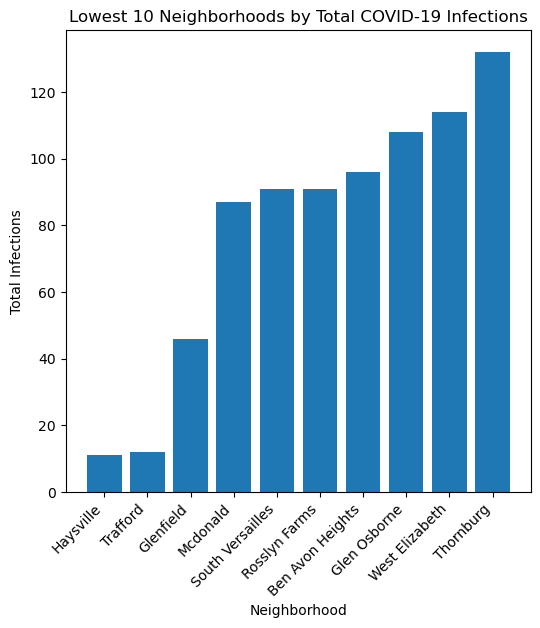

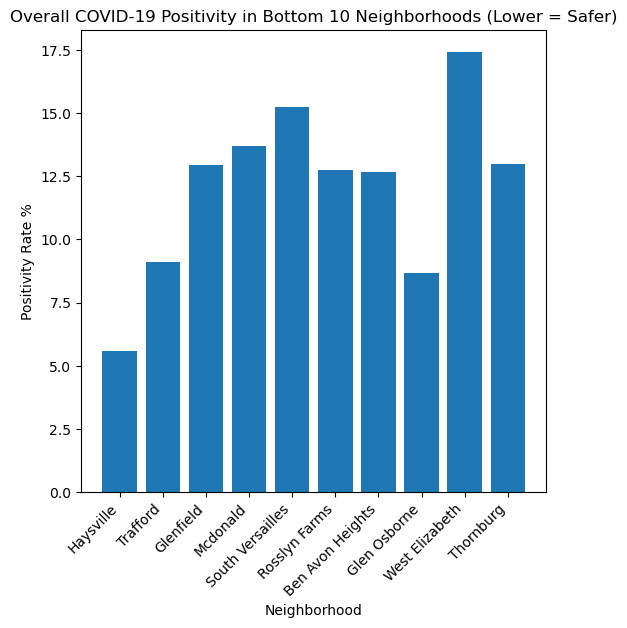

In [74]:
# lowest 10 neighborhoods by total infections and positivity rate

# bottom 10 neighborhoods with the least infections
bottom10 = grouped.sort_values(by='infections', ascending=True).head(10)
print('Bottom 10 Places by COVID-19 Infections:')
print(bottom10.head(10))

plt.figure(figsize=(6,6))
plt.bar(bottom10['place'], bottom10['infections'])
plt.title('Lowest 10 Neighborhoods by Total COVID-19 Infections')
plt.xlabel('Neighborhood')
plt.ylabel('Total Infections')
plt.xticks(rotation=45, ha='right')
plt.show()

# positivity rates for the bottom 10 neighborhoods
plt.figure(figsize=(6,6))
plt.bar(bottom10['place'], bottom10['positivity_rate'])
plt.title('Overall COVID-19 Positivity in Bottom 10 Neighborhoods (Lower = Safer)')
plt.xlabel('Neighborhood')
plt.ylabel('Positivity Rate %')
plt.xticks(rotation=45, ha='right')
plt.show()


Conclusion:
* Based on both of the LOWEST charts, the neighborhoods with the lowest overall COVID burden are the ones that consistently appear at the bottom in terms of both positivity rates and total infections. 
    * Haysville stands out as the safest, showing the lowest positivity rate and one of the smallest total case counts. 
    * Trafford and Glenfield likewise have very low total infections and relatively low positivity, suggesting limited spread in those communities. 
    * McDonald also appears among the lowest-burden neighborhoods, with higher positivity than the others but still far fewer total infections compared to most neighborhoods. 
* Taken together, these results indicate that Haysville, Trafford, Glenfield, and McDonald experienced the least COVID-19 impact across both metrics.
* This submetric will be combined with the two other submetrics (911 medical dispatch and police incidents) to determine the safest neighborhood.